In [1]:
# Define path the folder and phase excel file from RRP
directory = '/mnt/home/9.0 Data Jobs/220226-IB-RSHYR/' # job folder
file_phase='TestingPhases__IchiBanIRC52_20211226.xlsx' # phase report
file_log='2021 RSHYR Sydney Hobart Yacht Race_sor.csv' # cleaned log
headerRow = 6 # row number of first phase in phase report

In [2]:
# Import excel spreadsheet to pandas data frame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# import using read_excel, using headercolumn as columnnames
phases_in = pd.read_excel(directory+file_phase, header=headerRow-1) 
phases_in = phases_in.dropna(subset=['StartTime']) # remove excess rows
log_in = pd.read_csv(directory+file_log) # import log using read_csv
# convert excel time to dattime and round to nearest second
log_in['Aedt'] = pd.to_datetime(log_in['Aedt'], unit='D', origin='1899-12-30').round('1s') 
# set categorical variable types
categoricalVariables = ['WaterBallast', 'SeaState', 'Sails', 'DayNight']
for var in categoricalVariables:
    phases_in[var] = phases_in[var].astype('category')
    catCount = phases_in.groupby(var).size()
    catCount = catCount/sum(catCount)
    drop = catCount[catCount < 0.01].index
    phases_in[var].cat.remove_categories(drop, inplace = True)
    
phases_in['DayNight'].cat.rename_categories(['Night', 'Day'], inplace=True) # change Daynight from 0/1 to night/Day
#create heel  bin for under, on and over heel trg
phases_in['HeelBin'] = pd.cut(phases_in['HEEL_DELTA'], bins=[-25,-.05, 0.5, 25], labels=['Under', 'On', 'Over'])
phases_in['BspBin'] = pd.cut(phases_in['BSPpol%'], bins=[0, 90, 98, 105, 200], labels=['<90', '90 to 98', '98 to 105', '> 105'])

/tmp/ipykernel_18035/1249518264.py:20: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  phases_in[var].cat.remove_categories(drop, inplace = True)
/tmp/ipykernel_18035/1249518264.py:20: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  phases_in[var].cat.remove_categories(drop, inplace = True)
/tmp/ipykernel_18035/1249518264.py:20: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  phases_in[var].cat.remove_categories(drop, inplace = True)
/tmp/ipykernel_18035/1249518264.py:20: FutureWarning: The `inplace` parameter in p

In [3]:
#create time series graphs
time_seriesVars = ['BSP', 'TWA','TWS','TWD'] # variables to create tiem series of
for var in time_seriesVars: # loop over variables
    plt.figure(figsize=(20,2)) # make elongated figure
    timeSeries = sns.lineplot(data=log_in, x='Aedt', y=var, lw=0.5) # create time serries plot
    timeSeries.set_title(var+' Vs time') # add title
    sns.despine() # remove outline box
    plt.savefig(var+'_timeSeries.png') # save as .png
    plt.clf() # close plot figure so it is not over plotted

<Figure size 1440x144 with 0 Axes>

<Figure size 1440x144 with 0 Axes>

<Figure size 1440x144 with 0 Axes>

<Figure size 1440x144 with 0 Axes>

In [6]:
#create frequency distribution plots of relevant continous variables

densityVars = ['TwsBin', 'TwaBin', 'BSPpol%'] # select variables to plot
for var in densityVars: # loop over each variable in list of variables
    overallDensity = sns.histplot(data=phases_in, x=var, kde=True) # create seaborn plot
    overallDensity.set_title(var+' Freqency Count') # add title
    sns.despine() # remove outline box
    plt.savefig(var) # save as .png
    plt.clf() # close plot figure so it is not over plotted



<Figure size 432x288 with 0 Axes>

In [7]:
#create class count bar plots for categorical variables
countVars = ['WaterBallast', 'SeaState', 'Sails', 'DayNight', 'HeelBin'] # Select relevant variables

for var in countVars: # loop over var in variables
    overallCount = sns.countplot(y=var, data=phases_in, color="c") # create seaborne plot
    overallCount.set_title(var+' Category Count') # set title
    sns.despine() # remove outline box
    plt.savefig(var) # save plot
    plt.clf() # close plot figure so it is not over plotted


<Figure size 432x288 with 0 Axes>

In [8]:
# create hist plot of TWS and TWA
TwaTws_hist = sns.histplot(data=log_in.abs(), x='TWA', y='TWS')
TwaTws_hist.set_title('Frequency of Twa vs TWS')
sns.despine
plt.savefig("TwsTwa_hist.png")
plt.clf()

UFuncTypeError: ufunc 'absolute' did not contain a loop with signature matching types dtype('<M8[ns]') -> dtype('<M8[ns]')

In [ ]:
# create density plots for categorigal variables and for avgpol%
densityVars = ['WaterBallast', 'SeaState', 'HeelBin', 'BspBin'] # select relevant variables
for var in densityVars:# loop over variables
    # create joing density plots
    densityPlot = sns.displot(data=phases_in, x="TwaBin", y="TwsBin", kind="kde", hue=var, col= var, levels=10)
    densityPlot.fig.subplots_adjust(top=0.9) # adjust the Figure for space for title
    densityPlot.fig.suptitle('Density of '+var+' By TWS and TWA') # set title
    sns.despine() # remove outline box
    plt.savefig(var+'_joint.png') # save plot
    plt.clf() # close plot figure so it is not over plotted

In [ ]:
# create facet grids
facetVars = ['SeaState', 'HeelBin']
for var in facetVars:
    grid_1 = sns.FacetGrid(data = phases_in, col=var, hue = 'WaterBallast')
    grid_1.map(sns.kdeplot,'BSPpol%')
    grid_1.add_legend()
    plt.savefig(var+"_facetGrid.png") # save plot
    plt.clf() # close plot figure so it is not over plotted

In [78]:
# detail variables to keep for ballast analysis
ballast_variables = ['Sails','TwsBin','TwaBin','WaterBallast', 'BSPpol%', 'HEEL_TRG', 'HEEL_DELTA', 'HEEL']
# create new DF to show class balance and count for water ballast
ballast_bal = phases_in[ballast_variables] 
# group phases by TWS/TWA and count 'WaterBallast' class freqnecies
ballast_bal = phases_in.groupby(['TwsBin','TwaBin'], as_index=False).WaterBallast.value_counts(normalize=True) 
# drop NA's and reset index
ballast_bal = ballast_bal.loc[ballast_bal['WaterBallast'] == 'Empty'].dropna().reset_index() 
# rescale so as 0 and 1 are the same
ballast_bal['Imbalance'] = abs(0.5 - ballast_bal['proportion']) 
# count the number of entries in each bin
ballast_bal['count'] = phases_in.groupby(['TwsBin','TwaBin'], as_index=False).WaterBallast.count().WaterBallast 

<AxesSubplot:xlabel='TwaBin', ylabel='TwsBin'>

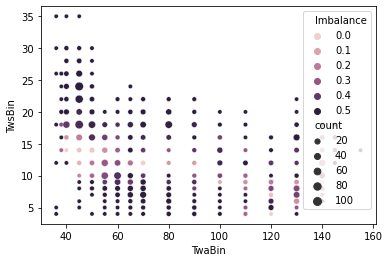

In [79]:
sns.scatterplot(x='TwaBin', y='TwsBin', hue='Imbalance', size='count', data=ballast_bal)

In [87]:
ballast_test_TwsBin = ballast_bal.loc[((ballast_bal['Imbalance'] < 0.2) & (ballast_bal['count'] > 10))].TwsBin.reset_index()
ballast_test_TwsBin = list(ballast_test_TwsBin['TwsBin'])
ballast_test_TwaBin = ballast_bal.loc[((ballast_bal['Imbalance'] < 0.2) & (ballast_bal['count'] > 10))].TwaBin.reset_index()
ballast_test_TwaBin = list(ballast_test_TwaBin['TwaBin'])


In [88]:
#for i in range(len(ballast_test_TwsBin)):
twa = ballast_test_TwaBin[1]
tws = ballast_test_TwsBin[1]
ballast_test = phases_in[((phases_in.TwaBin == twa) & (phases_in.TwsBin == tws))]

6
7


/tmp/ipykernel_5502/1702717403.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  avg = ballast_test.groupby(['WaterBallast']).mean()['BSPpol%']


<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

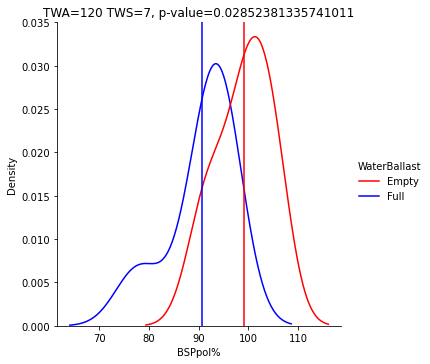

In [89]:
ballast_test = ballast_test[ballast_variables]
full_BSPpol = ballast_test[ballast_test.WaterBallast == 'Full']
empty_BSPpol = ballast_test[ballast_test.WaterBallast == 'Empty']
print(len(full_BSPpol))
print(len(empty_BSPpol))
tTest = stats.ttest_ind(full_BSPpol['BSPpol%'], empty_BSPpol['BSPpol%'])
test_plot = sns.displot(ballast_test, x='BSPpol%', hue='WaterBallast', kind='kde', palette = ['red','blue'] )
avg = ballast_test.groupby(['WaterBallast']).mean()['BSPpol%']
plt.axvline(x=avg[0], color = 'red')
plt.axvline(x=avg[1], color = 'blue')
test_plot.set(title = 'TWA='+str(twa)+' TWS='+str(tws)+ ', p-value='+str(tTest[1])) # set title
sns.despine

    #plt.savefig(str(i))
    #plt.clf()

In [90]:
ballast_test


,Sails,TwsBin,TwaBin,WaterBallast,BSPpol%,HEEL_TRG,HEEL_DELTA,HEEL
471,NaN,7,120,Empty,90.5,8,1.6,-9.9
472,NaN,7,120,Empty,93.5,11,1.7,-12.6
473,NaN,7,120,Empty,99.8,11,0.7,-11.3
474,NaN,7,120,Empty,98.5,11,0.7,-12
475,OM-C/J0-A/GS-E,7,120,Empty,104.9,11,-0.7,-9.7
476,OM-C/J0-A/GS-E,7,120,Empty,101.3,10,-0.8,-8.5
477,OM-C/J0-A/GS-E,7,120,Empty,105,10,-1.1,-9
478,OM-C/J0-A/GS-E,7,120,Full,94.7,11,-0.5,-10
479,OM-C/J0-A/GS-E,7,120,Full,89.2,10,-0.8,-8.9
480,OM-C/J0-A/GS-E,7,120,Full,94.8,10,-0.3,-9.6


In [91]:
twa = 130
tws = 6
ballast_test = phases_in[((phases_in.TwaBin == twa) & (phases_in.TwsBin == tws))]
ballast_test = ballast_test[ballast_variables]

In [92]:
test

NameError: name 'test' is not defined

/tmp/ipykernel_5502/582434631.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  avg = ballast_test.groupby(['WaterBallast']).mean()['BSPpol%']


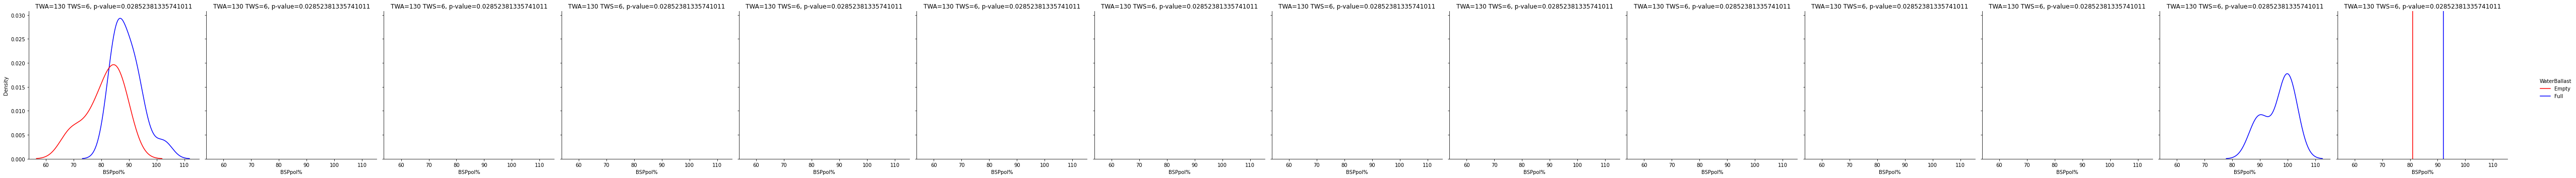

In [94]:
test_plot = sns.displot(ballast_test, x='BSPpol%', hue='WaterBallast', kind='kde', palette = ['red','blue'], col='Sails' )
avg = ballast_test.groupby(['WaterBallast']).mean()['BSPpol%']
plt.axvline(x=avg[0], color = 'red')
plt.axvline(x=avg[1], color = 'blue')
test_plot.set(title = 'TWA='+str(twa)+' TWS='+str(tws)+ ', p-value='+str(tTest[1])) # set title

In [198]:
ballast_test.groupby(['WaterBallast']).mean()['BSPpol%'][1]

92.02083333333333

In [197]:
ballast_test.groupby(['WaterBallast']).mean().index

CategoricalIndex(['Empty', 'Full'], categories=['Empty', 'Full'], ordered=False, dtype='category', name='WaterBallast')